In [1]:
# For now aerobulk installation only worked on greene not laptop
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from aerobulk.flux import noskin_np, skin_np, noskin, skin

In [3]:
ds = xr.load_dataset('../MLFLUXES/data/fluxes_all_cruises_compilation.nc')
ds_clean = ds.dropna(dim="time", how="any", 
                     subset=['taucx','taucy','hsc','hlc','U','tsnk','ta','qa'])

/ext3/miniconda3/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/ext3/miniconda3/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [4]:
# Valid data range according to documentation
# https://github.com/xgcm/aerobulk-python/blob/main/source/aerobulk/flux.py
VALID_VALUE_RANGES = {
    "sst": [270, 320],
    "t_zt": [180, 330],
    "hum_zt": [0, 0.08],
    "u_zu": [-50, 50],
    "v_zu": [-50, 50],
    "slp": [80000, 110000],
    "rad_sw": [0, 1500],
    "rad_lw": [0, 750],
}

### Use `noskin_np` and `skin_np` for inputs that are numpy arrays

In [5]:
# Pick one time
sst = ds_clean.isel(time=1).tsnk.values + 273.15   # from celsius to kelvin
t_zt = ds_clean.isel(time=1).ta.values + 273.15
hum_zt = ds_clean.isel(time=1).qa.values / 1000.  # from g/kg to kg/kg
u_zu = ds_clean.isel(time=1).U.values
v_zu = 0
zt = ds_clean.isel(time=1).zt.values
zu = ds_clean.isel(time=1).zu.values

# Cast scalar into numpy array
sst = np.reshape(sst,(-1,1))
t_zt = np.reshape(t_zt,(-1,1))
hum_zt = np.reshape(hum_zt,(-1,1))
u_zu = np.reshape(u_zu,(-1,1))
v_zu = np.reshape(v_zu,(-1,1))
zt = np.reshape(zt,(-1,1))
zu = np.reshape(zu,(-1,1))
slp = np.reshape(np.array([101000.0]),(-1,1))


In [6]:
algo = 'coare3p6'
ql, qh, taux, tauy, evap = noskin_np(sst=sst, t_zt=t_zt, hum_zt=hum_zt, u_zu=u_zu, v_zu=v_zu, slp=slp, algo=algo, zt=zt, zu=zu, 
                                     niter=10, input_range_check=VALID_VALUE_RANGES)

In [7]:
# Campare with bulk provided in the netcdf file. 
# THEY DON'T MATCH EXACTLY. NOT SURE WHY.
print(ql, ds_clean.isel(time=1).hlb.values)
print(qh, ds_clean.isel(time=1).hsb.values)
print(taux, ds_clean.isel(time=1).taub.values)
print(tauy) # spanwise stress is zero

[[-173.07840618]] 180.59
[[-80.84056598]] 77.11
[[0.60570361]] 0.5671
[[0.]]


### Use `noskin` and `skin` for inputs that are xarrays

In [27]:
# When calling noskin, slp has default value 101000.0, niter has default value 6, input_range_check by default True
# For me the default slp=101000.0 thing didn't work with the error "'float' object has no attribute 'xindexes'"
# So I had to cast it into data array first
# Also I have checked that tauy is zero 
# Also ql and qh seem to be in different sign convention than the ones in netcdf file
ql, qh, taux, tauy, evap = noskin(sst=ds_clean.tsnk + 273.15, t_zt=ds_clean.ta + 273.15, 
                                  hum_zt=ds_clean.qa/1000., u_zu=ds_clean.U, 
                                  v_zu=ds_clean.U*0, slp=ds_clean.U/ds_clean.U*101000.0, algo='ncar', zt=ds_clean.zt, 
                                  zu=ds_clean.zu)

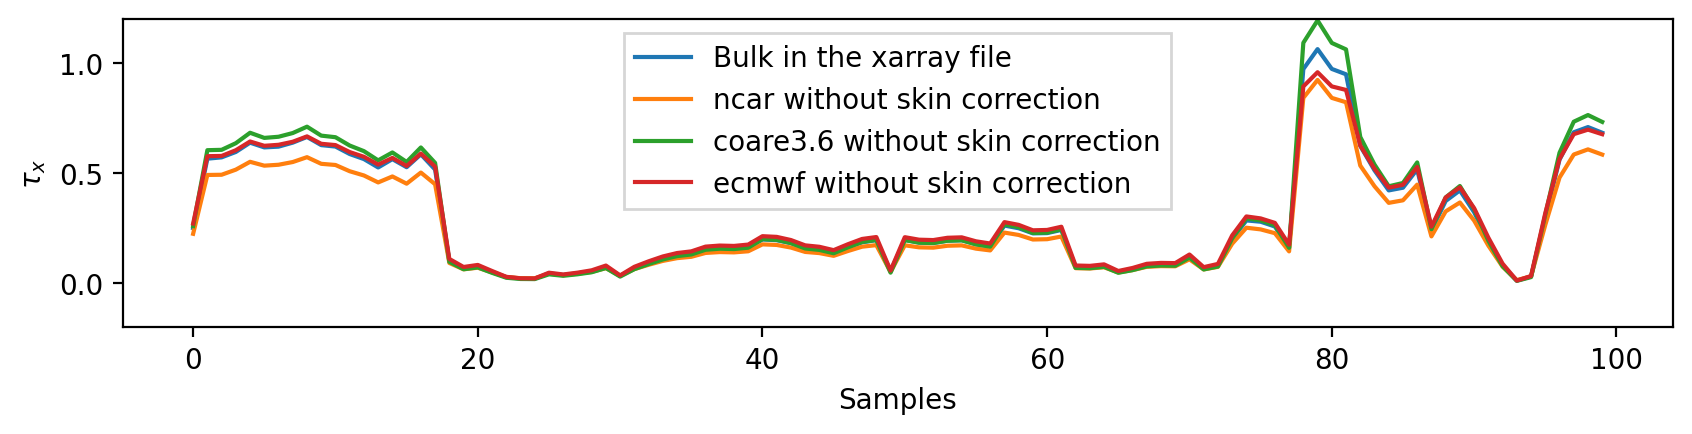

In [56]:
# Check which bulk formula was used for "bulk quantites provided in original netcdf file 
# According to manual, the bulk in the netcdf data file is computed with COARE3.5 
# (includes Webb et al. correction for latent heat) 

fig = plt.figure(figsize=[10,2],dpi=200)

plt.plot(ds_clean.taub[:100], label='Bulk in the xarray file')

ql, qh, taux, tauy, evap = noskin(sst=ds_clean.tsnk + 273.15, t_zt=ds_clean.ta + 273.15, 
                                  hum_zt=ds_clean.qa/1000., u_zu=ds_clean.U, 
                                  v_zu=ds_clean.U*0, slp=ds_clean.U/ds_clean.U*101000.0, algo='ncar', zt=ds_clean.zt, 
                                  zu=ds_clean.zu)
plt.plot(taux[:100], label='ncar without skin correction') # display first 100 points

ql, qh, taux, tauy, evap = noskin(sst=ds_clean.tsnk + 273.15, t_zt=ds_clean.ta + 273.15, 
                                hum_zt=ds_clean.qa/1000., u_zu=ds_clean.U, 
                                v_zu=ds_clean.U*0, slp=ds_clean.U/ds_clean.U*101000.0, algo='coare3p6', zt=ds_clean.zt, 
                                zu=ds_clean.zu)
plt.plot(taux[:100], label='coare3.6 without skin correction') # display first 100 points

ql, qh, taux, tauy, evap = noskin(sst=ds_clean.tsnk + 273.15, t_zt=ds_clean.ta + 273.15, 
                                hum_zt=ds_clean.qa/1000., u_zu=ds_clean.U, 
                                v_zu=ds_clean.U*0, slp=ds_clean.U/ds_clean.U*101000.0, algo='ecmwf', zt=ds_clean.zt, 
                                zu=ds_clean.zu)
plt.plot(taux[:100], label='ecmwf without skin correction') # display first 100 points

plt.xlabel('Samples'); plt.ylabel(r'$\tau_x$'); plt.ylim([-0.2,1.2])
plt.legend(fancybox=False)

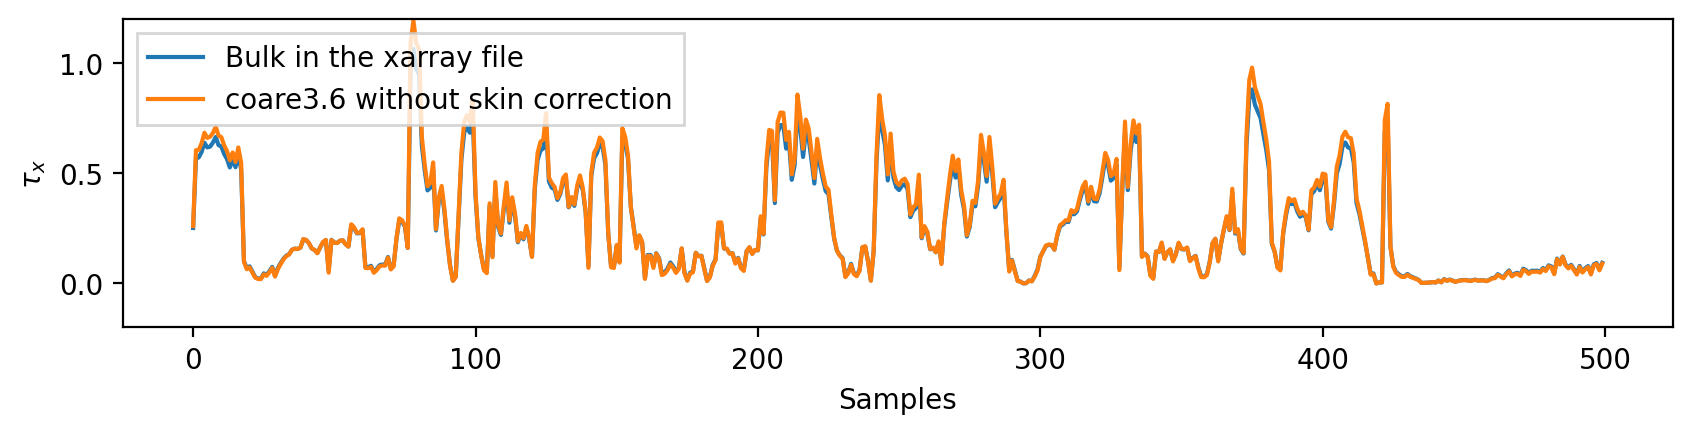

In [20]:
# Several other attempts

fig = plt.figure(figsize=[10,2],dpi=200)

plt.plot(ds_clean.taub[:500], label='Bulk in the xarray file')

ql, qh, taux, tauy, evap = noskin(sst=ds_clean.tsnk + 273.15, t_zt=ds_clean.ta + 273.15, 
                                hum_zt=ds_clean.qa/1000., u_zu=ds_clean.U, 
                                v_zu=ds_clean.U*0, slp=ds_clean.U/ds_clean.U*101000.0, algo='coare3p6', zt=ds_clean.zt, 
                                zu=ds_clean.zu, niter=20)
plt.plot(taux[:500], label='coare3.6 without skin correction') # display first 100 points

# ql, qh, taux, tauy, evap = noskin(sst=ds_clean.tsnk + 273.15, t_zt=ds_clean.ta + 273.15, 
#                                 hum_zt=ds_clean.qa/1000., u_zu=ds_clean.U, 
#                                 v_zu=ds_clean.U*0, slp=ds_clean.U/ds_clean.U*101000.0, algo='coare3p6', zt=ds_clean.zt, 
#                                 zu=ds_clean.zu, niter=100)
# plt.plot(taux[:100], label='coare3.6 without skin correction') # display first 100 points

# ql, qh, taux, tauy, evap = noskin(sst=ds_clean.tsnk + 273.15, t_zt=ds_clean.ta + 273.15, 
#                                 hum_zt=ds_clean.qa/1000., u_zu=ds_clean.U, 
#                                 v_zu=ds_clean.U*0, slp=ds_clean.dummy1*100, algo='coare3p6', zt=ds_clean.zt, 
#                                 zu=ds_clean.zu, input_range_check=False)
# plt.plot(taux[-100:], label='coare3.6 without skin correction, pressure') # display first 100 points

# I somehow needed to turn off input_range_check otherwise it throws a weird error saying that slp is out of range 
# when it's clearly in range
# instead of tsnk (~0.05m depth) use tsg (~5m depth)
# ql, qh, taux, tauy, t_s, evap = skin(sst=ds_clean.tsg + 273.15, t_zt=ds_clean.ta + 273.15, 
#                                 hum_zt=ds_clean.qa/1000., u_zu=ds_clean.U, 
#                                 v_zu=ds_clean.U*0, slp=ds_clean.U/ds_clean.U*101000.0, algo='coare3p6', zt=ds_clean.zt, 
#                                 zu=ds_clean.zu, rad_sw=ds_clean.rs, rad_lw=ds_clean.rl, input_range_check=False, niter=10)
# plt.plot(taux[:100], label='coare3.6 with skin correction') # display first 100 points


plt.xlabel('Samples'); plt.ylabel(r'$\tau_x$'); plt.ylim([-0.2,1.2])
plt.legend(fancybox=False)

/ext3/miniconda3/lib/python3.11/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
  warnings.warn(performance_msg)


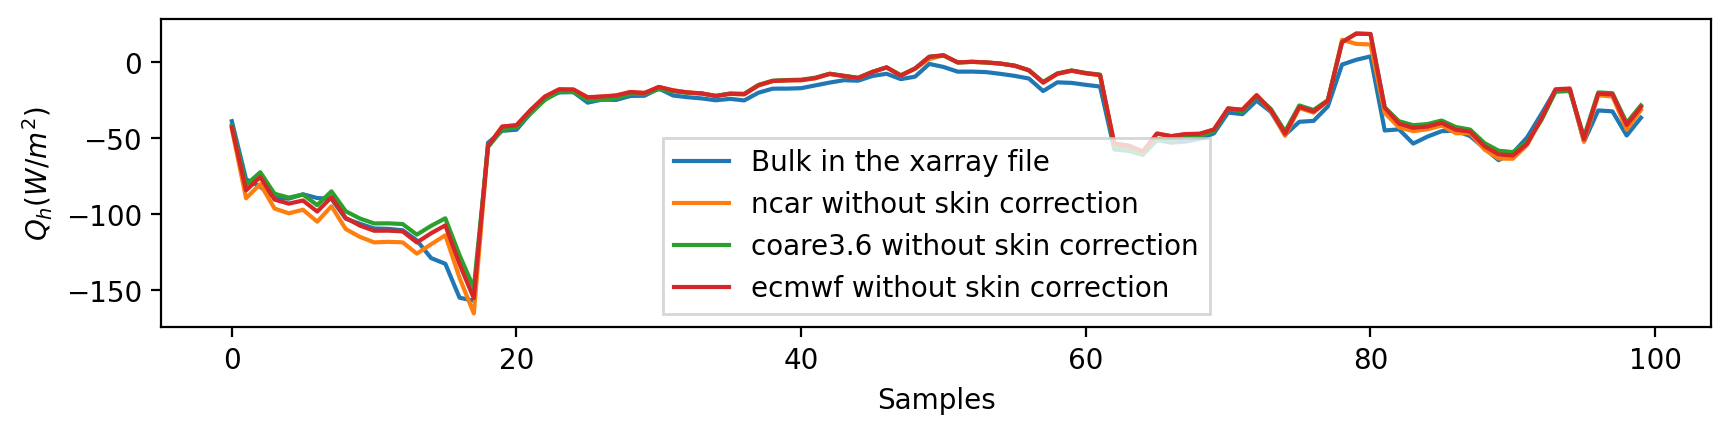

In [62]:
# For sensible heat

fig = plt.figure(figsize=[10,2],dpi=200)

plt.plot(-ds_clean.hsb[:100], label='Bulk in the xarray file')

ql, qh, taux, tauy, evap = noskin(sst=ds_clean.tsnk + 273.15, t_zt=ds_clean.ta + 273.15, 
                                  hum_zt=ds_clean.qa/1000., u_zu=ds_clean.U, 
                                  v_zu=ds_clean.U*0, slp=ds_clean.U/ds_clean.U*101000.0, algo='ncar', zt=ds_clean.zt, 
                                  zu=ds_clean.zu)
plt.plot(qh[:100], label='ncar without skin correction') # display first 100 points

ql, qh, taux, tauy, evap = noskin(sst=ds_clean.tsnk + 273.15, t_zt=ds_clean.ta + 273.15, 
                                hum_zt=ds_clean.qa/1000., u_zu=ds_clean.U, 
                                v_zu=ds_clean.U*0, slp=ds_clean.U/ds_clean.U*101000.0, algo='coare3p6', zt=ds_clean.zt, 
                                zu=ds_clean.zu)
plt.plot(qh[:100], label='coare3.6 without skin correction') # display first 100 points

ql, qh, taux, tauy, evap = noskin(sst=ds_clean.tsnk + 273.15, t_zt=ds_clean.ta + 273.15, 
                                hum_zt=ds_clean.qa/1000., u_zu=ds_clean.U, 
                                v_zu=ds_clean.U*0, slp=ds_clean.U/ds_clean.U*101000.0, algo='ecmwf', zt=ds_clean.zt, 
                                zu=ds_clean.zu)
plt.plot(qh[:100], label='ecmwf without skin correction') # display first 100 points

# ql, qh, taux, tauy, t_s, evap = skin(sst=ds_clean.tsnk + 273.15, t_zt=ds_clean.ta + 273.15, 
#                                 hum_zt=ds_clean.qa/1000., u_zu=ds_clean.U, 
#                                 v_zu=ds_clean.U*0, slp=ds_clean.U/ds_clean.U*101000.0, algo='coare3p6', zt=ds_clean.zt, 
#                                 zu=ds_clean.zu, rad_sw=ds_clean.rs, rad_lw=ds_clean.rl, input_range_check=False)

plt.xlabel('Samples'); plt.ylabel(r'$Q_h (W/m^2)$'); 
# plt.ylim([-0.2,1.2])
plt.legend(fancybox=False)

/ext3/miniconda3/lib/python3.11/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
  warnings.warn(performance_msg)


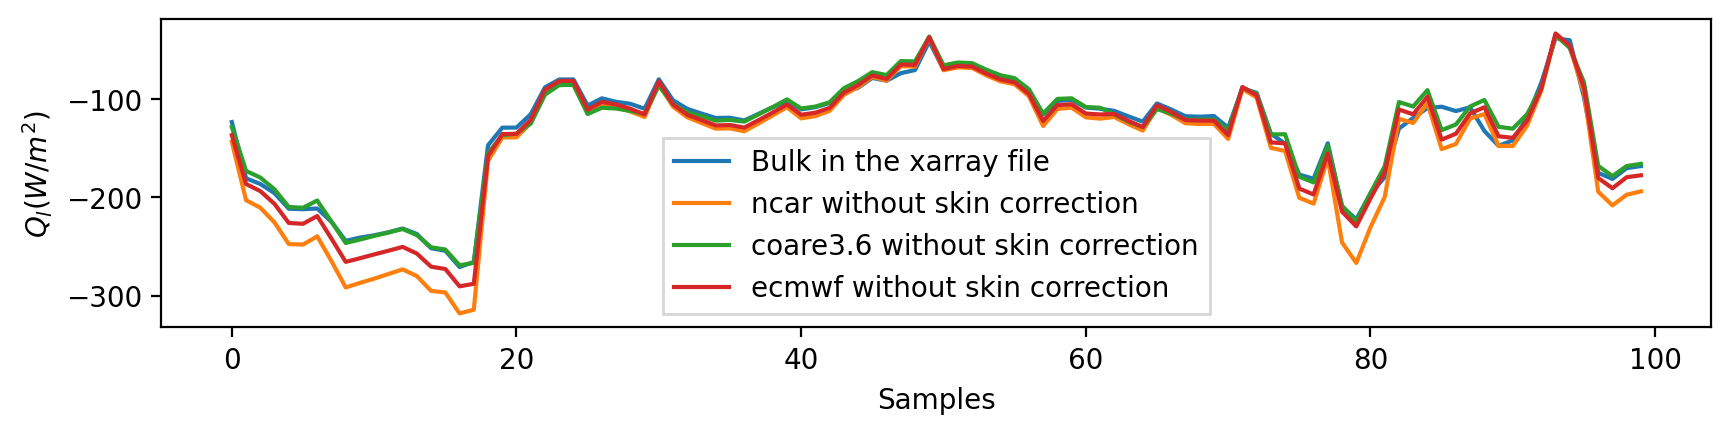

In [63]:
# For latent heat 

fig = plt.figure(figsize=[10,2],dpi=200)

plt.plot(-ds_clean.hlb[:100], label='Bulk in the xarray file')

ql, qh, taux, tauy, evap = noskin(sst=ds_clean.tsnk + 273.15, t_zt=ds_clean.ta + 273.15, 
                                  hum_zt=ds_clean.qa/1000., u_zu=ds_clean.U, 
                                  v_zu=ds_clean.U*0, slp=ds_clean.U/ds_clean.U*101000.0, algo='ncar', zt=ds_clean.zt, 
                                  zu=ds_clean.zu)
plt.plot(ql[:100], label='ncar without skin correction') # display first 100 points

ql, qh, taux, tauy, evap = noskin(sst=ds_clean.tsnk + 273.15, t_zt=ds_clean.ta + 273.15, 
                                hum_zt=ds_clean.qa/1000., u_zu=ds_clean.U, 
                                v_zu=ds_clean.U*0, slp=ds_clean.U/ds_clean.U*101000.0, algo='coare3p6', zt=ds_clean.zt, 
                                zu=ds_clean.zu)
plt.plot(ql[:100], label='coare3.6 without skin correction') # display first 100 points

ql, qh, taux, tauy, evap = noskin(sst=ds_clean.tsnk + 273.15, t_zt=ds_clean.ta + 273.15, 
                                hum_zt=ds_clean.qa/1000., u_zu=ds_clean.U, 
                                v_zu=ds_clean.U*0, slp=ds_clean.U/ds_clean.U*101000.0, algo='ecmwf', zt=ds_clean.zt, 
                                zu=ds_clean.zu)
plt.plot(ql[:100], label='ecmwf without skin correction') # display first 100 points

# ql, qh, taux, tauy, t_s, evap = skin(sst=ds_clean.tsnk + 273.15, t_zt=ds_clean.ta + 273.15, 
#                                 hum_zt=ds_clean.qa/1000., u_zu=ds_clean.U, 
#                                 v_zu=ds_clean.U*0, slp=ds_clean.U/ds_clean.U*101000.0, algo='coare3p6', zt=ds_clean.zt, 
#                                 zu=ds_clean.zu, rad_sw=ds_clean.rs, rad_lw=ds_clean.rl, input_range_check=False)

plt.xlabel('Samples'); plt.ylabel(r'$Q_l (W/m^2)$'); 
# plt.ylim([-0.2,1.2])
plt.legend(fancybox=False)